In [1]:
## All library imports ##

import numpy as np

import sympy as sp

import math

# import astropy
# from astropy import units as u
# from astropy.timeseries import TimeSeries
# from astropy.utils.data import download_file
# from astropy.convolution import convolve, Box1DKernel

from scipy import stats #Linear regression

import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.axes
from matplotlib.colors import LogNorm #Colour bars etc.

import matplotlib.backends.backend_pdf #For creating PDFs

from matplotlib.legend import Legend #For creating multiple legends in one plot

import os #For making directories

In [2]:
#Putting this information into arrays and defining necessary variables
#For easy access later

indexes = [[0,1,2,3],[1,2,46],[1,14,18,52],[0,1],[1],[0,2,8],[1,4,12,14,30,32]]
# indexes = [0,1,2,3,1,2,46,1,14,18,52,0,1,1,0,2,8,1,4,12,14,30,32]
regions = ['SERPENS_MAIN','SERPENS_SOUTH','OMC23','IC348','OPH_CORE','NGC1333','NGC2071']
num_regions = int(len(regions))
num_rands = 100 #For later use creating 100 randomizations of each data point for each source

In [3]:
## Importing ALL JCMT regions ##

# num_fluxes = int(len(metadata_list)) #Number of flux values for each source

sourceinfo_file = [[] for i in range(num_regions)]
metadata_file = [[] for i in range(num_regions)]

for i in range(num_regions): #For a given region
    sourceinfo_file[i] = open(r"C:\\Users\\spenc\\Documents\\Johnstone_Data\\"+regions[i]+\
                          "_850_EA3_source_info.txt","r")
    metadata_file[i] = open(r"C:\\Users\\spenc\\Documents\\Johnstone_Data\\"+regions[i]+\
                          "_850_EA3_cal_metadata.txt","r")


sources_list = [[] for i in range(num_regions)]
metadata_list = [[] for i in range(num_regions)]

num_fluxes = np.zeros(num_regions)
num_sources = np.zeros(num_regions)

for i in range(num_regions):
    sourceinfo_file[i].readline() #Reads past titles
    sourceinfo = sourceinfo_file[i].readlines() #Temporary variable

    metadata_file[i].readline()
    metadata = metadata_file[i].readlines()

    
    for line in sourceinfo:
        sources_list[i].append(line.split()) #Splits up the strings into values in a list (for a given region)

    for line in metadata:
        metadata_list[i].append(line.split()) 

    num_fluxes[i] = int(len(metadata_list[i]))
    num_sources[i] = int(len(sources_list[i]))


flux_all = []

for i in range(num_regions):
    flux_all.append([])
    for j in range(int(num_sources[i])): #For a given source in a region
        flux_all[i].append([])
        for k in range(int(num_fluxes[i])): #For a given flux value for that source in that region
            flux_all[i][j].append(sources_list[i][j][k+15]) #Appending all flux values for a given source


time = []
for i in range(num_regions):
    time.append([])
    for j in range(int(num_fluxes[i])):
        time[i].append(float(metadata_list[i][j][4]))
        

#Manipulating the time data as necessary

start = np.zeros(num_regions)
for i in range(num_regions):
    start[i] = time[i][0]
    for j in range(len(time[i])):
        time[i][j] -= start[i] #Starting time at zero instead of Julian dates for cleaner appearance

for i in range(num_regions):
    for j in range(len(time[i])):
        time[i][j] = time[i][j]/365.25 #Converting time from days to years

In [4]:
## Cherry-picking the sources we want ##
#Grabbing from the 'flux_all' list

flux = []
for i in range(num_regions):
    flux.append([])
    for j in range(int(len(indexes[i]))): #Number of sources we WANT from a certain region
        flux[i].append([])
        flux[i][j] = flux_all[i][int(indexes[i][j])]

#Converting the flux and time lists to arrays

flux = np.array(flux)
time = np.array(time)

In [5]:
#Converting all values in the flux array to floats

for i in range(num_regions):
    for j in range(int(len(indexes[i]))):
        for k in range(int(num_fluxes[i])):
            flux[i][j][k] = float(flux[i][j][k])

In [6]:
#Using functions to grab info about sources
#For use in plots

#Grabbing RA, DEC info
def info(sources_list): #For a given source, 1D list
    
    RA = round(float(sources_list[2]),3)
    DEC = round(float(sources_list[3]),3)
        
    return (RA, DEC) #Singular values


#Find mean flux values
def mean(flux): #For a given source, 1D list
    
    fluxm = round(np.mean(flux)*1000,3) #Converting to milliJansky
    
    return fluxm


RA = []
DEC = []
flux_mean = []
for i in range(num_regions):
    RA.append([])
    DEC.append([])
    flux_mean.append([])
    for j in range(len(indexes[i])):
        RA[i].append(info(sources_list[i][j])[0])
        DEC[i].append(info(sources_list[i][j])[1])
        flux_mean[i].append(mean(flux[i][j]))
        
    sourceinfo_file[i].close()
    metadata_file[i].close()

In [7]:
#Used for the histogram
elem_time = int(15)
elem_flux = int(15)
bins_time = [(1.5**(i+4))/365.25 for i in range(elem_time+1)]
bins_flux = [((2**(i-9))/10) for i in range(elem_flux+1)]

bins_time = np.asarray(bins_time)
bins_flux = np.asarray(bins_flux)

In [8]:
#Function to construct dtime, dflux variable
#ex. use 'time[0]' or flux[0][0]'
global dtime
def pairs(var):
    
    num_pairs = int(len(var)*(len(var)-1)/2)
    pairs = np.zeros(num_pairs)
    
    
    #Creating the time/mass/etc. pairs
    count = 0
    for i in range(len(var)):
        for j in range(i+1,len(var)):
            pairs[count] = abs(var[i] - var[j])
            count += 1
    
    return pairs



dtime = [[] for i in range(num_regions)]
dflux = []
num_fluxpairs = []

for i in range(num_regions):
    dtime[i] = pairs(time[i])
    dflux.append([])
    for j in range(len(indexes[i])): #For each source in a region
        dflux[i].append([])
        dflux[i][j] = pairs(flux[i][j])
        
    num_fluxpairs.append(len(dflux[i][j]))

#Converting to arrays
dtime = np.asarray(dtime)
dflux = np.asarray(dflux)

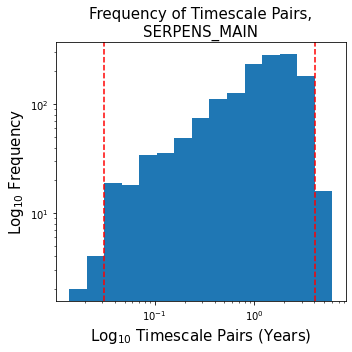

In [9]:
## Just a plot of the histogram timescale pairs ##
## Checking dtime variable ##

r = 0 #Input index value for specified region

plt.figure(figsize=(5,5))
plt.title('Frequency of Timescale Pairs,\n'+regions[r], fontsize=15)
plt.ylabel('Log$_{10}$ Frequency', fontsize=15)
plt.xlabel('Log$_{10}$ Timescale Pairs (Years)', fontsize=15)

(n, bins, patches) = plt.hist(dtime[r], bins_time)

plt.axvline(x=bins_time[2], color='r', linestyle='dashed')
plt.axvline(x=bins_time[-2], color='r', linestyle='dashed')
        
plt.yscale('log')
plt.xscale('log')
plt.tight_layout()

In [10]:
## Creating the structure function variable ##

dflux_sq = []
#Creating 3D array for squared flux pairs for each flux pair for each source in each region
flux_med_sq = []
#Finding a median squared flux value for each source in each region


#Appending values for these variables
for i in range(num_regions): #For a given region
    flux_med_sq.append([])
    dflux_sq.append([])
    for j in range(int(len(indexes[i]))): #Number of sources in a region
        flux_med_sq[i].append((np.median(flux[i][j]))**2)
        dflux_sq[i].append([])
        for k in range(num_fluxpairs[i]): #Number of fluxpairs in a region (constant across sources in a region)
            dflux_sq[i][j].append(np.square(dflux[i][j][k]))


for i in range(num_regions):
    for j in range(len(indexes[i])):
        dflux_sq[i][j] = np.array(dflux_sq[i][j])
        flux_med_sq[i][j] = np.array(flux_med_sq[i][j])


#Creating a function that spits out the SF
def sfunc(dtime, bins_time, dflux_sq, flux_med_sq): #All variables needed to create SF
    
    #REMEMBER: Assume these are all 1D!!! Create for loops around this!
    #Assume serpens main, EC53
    
    SF = []
    SF_fid = []
    fid_dflux_sq = []
    
    for i in range(elem_time):
        bin_data = [] #Empties the bin_data list for each SF data point
        
        dtbins = np.where((dtime >= bins_time[i]) & (dtime < bins_time[i+1]))[0]
        #dtbins = list of indices, an array within a list
        #np.where()[0] Tells you the indices where the data 
        #falls within a certain bin/where conditions are met

        if len(dtbins) > 0:
            
            bin_data = dflux_sq[dtbins] #Only works if dtbins is an array
            #Note that bin_data changes with every run through the loop
            #Note that this line does NOT work if you're using lists instead of arrays
            
            SF.append(np.sqrt((1/flux_med_sq)*(1/len(dtbins))*sum(bin_data)))
            #Appending the sum of the flux pair values for a specific bin
            #Dividing by the number of pairs in a specific bin, len(dtbins)
            #Dividing by the median flux of the source
            
            fid_dflux_sq = 0.015*0.015 + 0.02*0.02*flux_med_sq #Constant value for a given source
            SF_fid.append(np.sqrt((1/fid_dflux_sq)*(1/len(dtbins))*sum(bin_data)))
            #SF value normalized by the "expected" noise level
            
        else:
            SF.append(0)
            SF_fid.append(0)
            
    return (SF, SF_fid)
     

SF = []    
SF_fid = []
for i in range(num_regions): #For a given region
    SF.append([])
    SF_fid.append([])
    for j in range(len(indexes[i])): #For a given source in a region
        
        SF[i].append(sfunc(dtime[i],bins_time,dflux_sq[i][j],flux_med_sq[i][j])[0])
        SF_fid[i].append(sfunc(dtime[i],bins_time,dflux_sq[i][j],flux_med_sq[i][j])[1])

In [11]:
## Creating a linear regression line for each source from scipy.stats ##
## Then subtracting the linear fit value to remove secular variability ##

#Using a function
def linfit(time,flux):
    num_fluxes = int(len(flux))
    flux_fit = np.zeros(num_fluxes)
    flux_flat = np.zeros(num_fluxes)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(time,flux)
    
    for i in range(num_fluxes):
        flux_fit[i] = (slope*time[i] + intercept) #Using y = mx + b formula
        flux_flat[i] = flux[i] - flux_fit[i] #Subtracting the linear fit values

    return flux_flat


flux_flat = []
for i in range(num_regions): #For a given region
    flux_flat.append([])
    for j in range(len(indexes[i])): #For a given source
        flux_flat[i].append([])
        
        flux_flat[i][j] = linfit(time[i],flux[i][j])
        flux_flat[i][j] = np.asarray(flux_flat[i][j])

In [12]:
## Finding the flattened flux pairs ##

dflux_flat = []

for i in range(num_regions):
    dflux_flat.append([])
    for j in range(len(indexes[i])):
        dflux_flat[i].append([])
        
        dflux_flat[i][j] = pairs(flux_flat[i][j])
        dflux_flat[i][j] = np.array(dflux_flat[i][j])

In [13]:
## Creating the structure function variable using the flattened flux values ##

#Same process as before
dflux_flat_sq = []
flux_flat_med_sq = []

#Appending values for these variables
for i in range(num_regions): #For a given region
    flux_flat_med_sq.append([])
    dflux_flat_sq.append([])
    for j in range(int(len(indexes[i]))): #Number of sources in a region
        flux_flat_med_sq[i].append((np.median(flux_flat[i][j]))**2)
        dflux_flat_sq[i].append([])
        for k in range(num_fluxpairs[i]): #Number of fluxpairs in a region (constant across sources in a region)
            dflux_flat_sq[i][j].append(np.square(dflux_flat[i][j][k]))

#Converting to arrays in all dimensions - for loops necessary?
for i in range(num_regions):
    for j in range(len(indexes[i])):
        dflux_flat_sq[i][j] = np.array(dflux_flat_sq[i][j])
        flux_flat_med_sq[i][j] = np.array(flux_flat_med_sq[i][j]) #NOTE: Don't use flattened median squared value?
        
        
SF_flat = []    
SF_flat_fid = []
for i in range(num_regions): #For a given region
    SF_flat.append([])
    SF_flat_fid.append([])
    for j in range(len(indexes[i])): #For a given source in a region
        
        SF_flat[i].append(sfunc(dtime[i],bins_time,dflux_flat_sq[i][j],flux_med_sq[i][j])[0])
        SF_flat_fid[i].append(sfunc(dtime[i],bins_time,dflux_flat_sq[i][j],flux_med_sq[i][j])[1])

In [14]:
## Creating random values from 0 to 1 ##
#Creating 100 random values for EACH source, so we need a 3D array 
#Since for each source in the array, we have 100 instances of the flux values, now randomized

#For flattened, THEN randomized 
def randomizer(flux,flux_flat):
    
    num_fluxes = int(len(flux))
    
    rands = [] #flux
    #Creating a list of 100 random values (between 0 and 1)
    for i in range(num_rands):
        rands.append(np.random.random(int(num_fluxes)))
        
    rands_sorted_ind = []
    #Sorting the list of values by index
    for i in range(num_rands):
        rands_sorted_ind.append(rands[i].argsort())
    
    
    flux_rand = []
    flux_flat_rand = []
    for i in range(num_rands):
        flux_rand.append([])
        flux_flat_rand.append([])
        
        for j in range(int(num_fluxes)): #For flux --> rand
            flux_rand[i].append(flux[int(rands_sorted_ind[i][j])]) #Resorting - random, then flattened later
            flux_flat_rand[i].append(flux_flat[int(rands_sorted_ind[i][j])])
    
    #Important to check if this works
#     print(rands[0])
#     print(rands_sorted_ind[0])
#     print(flux)
#     print(flux_rand[0])
    
    return (flux_rand, flux_flat_rand)



flux_rand = []
flux_flat_rand = []
for i in range(num_regions): #For a given region
    flux_rand.append([])
    flux_flat_rand.append([])
    for j in range(len(indexes[i])): #For a given source in a region
        flux_rand[i].append([])
        flux_flat_rand[i].append([])
        
        flux_rand[i][j],flux_flat_rand[i][j] = randomizer(flux[i][j],flux_flat[i][j])
        #We now have 100 random versions of each light curve, before AND after randomization

In [15]:
## Finding the number of 'flattened' flux pairs for each random in each source ##
## !LONG RUNTIME! ##

dflux_rand = []
dflux_flat_rand = []

dflux_rand_sq = []
dflux_flat_rand_sq = []

for i in range(num_regions):
    dflux_rand.append([])
    dflux_flat_rand.append([])
    dflux_rand_sq.append([])
    dflux_flat_rand_sq.append([])
    
    for j in range(int(len(indexes[i]))):
        dflux_flat_rand[i].append([])
        dflux_rand[i].append([])
        dflux_rand_sq[i].append([])
        dflux_flat_rand_sq[i].append([])
        
        for k in range(num_rands):
            dflux_flat_rand[i][j].append([])
            dflux_rand[i][j].append([])
            dflux_rand_sq[i][j].append([])
            dflux_flat_rand_sq[i][j].append([])
            
            dflux_rand[i][j][k] = pairs(flux_rand[i][j][k])
            dflux_flat_rand[i][j][k] = pairs(flux_flat_rand[i][j][k])
            
            dflux_rand_sq[i][j][k] = np.square(dflux_rand[i][j][k])
            dflux_flat_rand_sq[i][j][k] = np.square(dflux_flat_rand[i][j][k])

In [16]:
# ## Converting the lists created above into arrays ##
# ## LONG RUNTIME! ##

# #Converting to arrays in all dimensions
# for i in range(num_regions):
#     for j in range(int(len(indexes[i]))):
#         flux_flat_rand_med_sq[i][j] = np.array(flux_flat_rand_med_sq[i][j])
#         flux_rand_med_sq[i][j] = np.array(flux_rand_med_sq[i][j])
#         for k in range(num_rands):
#             dflux_flat_rand_sq[i][j][k] = np.array(dflux_flat_rand_sq[i][j][k])
#             dflux_rand_sq[i][j][k] = np.array(dflux_rand_sq[i][j][k])

In [17]:
## Creating the structure function variable using the flattened flux values ##

SF_flat_rand = []
SF_flat_rand_fid = []
SF_rand = []
SF_rand_fid = []

for i in range(num_regions):
    SF_flat_rand.append([])
    SF_flat_rand_fid.append([])
    SF_rand.append([])
    SF_rand_fid.append([])
    
    for j in range(int(len(indexes[i]))):
        SF_flat_rand[i].append([])
        SF_flat_rand_fid[i].append([])
        SF_rand[i].append([])
        SF_rand_fid[i].append([])
        
        for k in range(num_rands):
            SF_rand[i][j].append([])
            SF_rand_fid[i][j].append([])
            SF_flat_rand[i][j].append([])
            SF_flat_rand_fid[i][j].append([])
            
            SF_rand[i][j][k],SF_rand_fid[i][j][k] = sfunc(dtime[i],bins_time,dflux_rand_sq[i][j][k],flux_med_sq[i][j])
            SF_flat_rand[i][j][k],SF_flat_rand_fid[i][j][k] = sfunc(dtime[i],bins_time,dflux_flat_rand_sq[i][j][k],flux_med_sq[i][j])

In [18]:
## Re-organizing the data by elem_time steps for easier use ##


SF_plot_randvalues = [] #To be arranged as per source, per time step, per random
SF_plot_flat_randvalues = []


for i in range(num_regions):
    SF_plot_randvalues.append([])
    SF_plot_flat_randvalues.append([])
    
    for j in range(int(len(indexes[i]))):
        SF_plot_randvalues[i].append([])
        SF_plot_flat_randvalues[i].append([])
                   
        for k in range(elem_time):
            SF_plot_randvalues[i][j].append([])
            SF_plot_flat_randvalues[i][j].append([])
                   
            for z in range(num_rands):
                #Switching randomized lightcurve and flux data point
                SF_plot_randvalues[i][j][k].append(SF_rand_fid[i][j][z][k])
                SF_plot_flat_randvalues[i][j][k].append(SF_flat_rand_fid[i][j][z][k])

In [19]:
## Creating error bar and mean randomization variables for plots in next cell ##

err = [] #Per source, per time step
err_flat = []

SF_randmeans = [] #""
SF_flat_randmeans = []


for i in range(num_regions):
    err.append([])
    err_flat.append([])
    SF_randmeans.append([])
    SF_flat_randmeans.append([])
    
    for j in range(int(len(indexes[i]))):
        err[i].append([])
        err_flat[i].append([])
        SF_randmeans[i].append([])
        SF_flat_randmeans[i].append([])
        
        for k in range(elem_time):
            #Stdev of the 100 randomizations for a given data point on the SF
            err[i][j].append(np.std(SF_plot_randvalues[i][j][k]))
            err_flat[i][j].append(np.std(SF_plot_flat_randvalues[i][j][k]))
            
            #Using the mean value of the 100 SF randomizations to plot
            SF_randmeans[i][j].append(np.mean(SF_plot_randvalues[i][j][k]))
            SF_flat_randmeans[i][j].append(np.mean(SF_plot_flat_randvalues[i][j][k]))

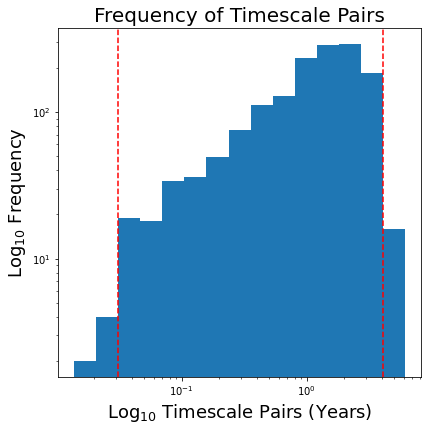

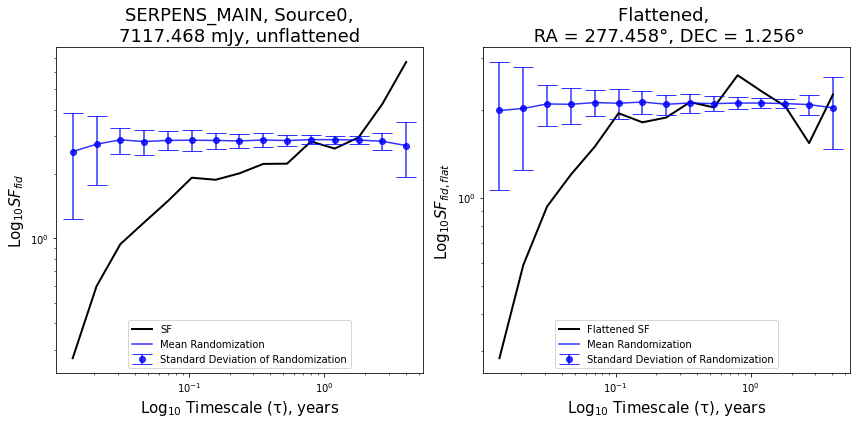

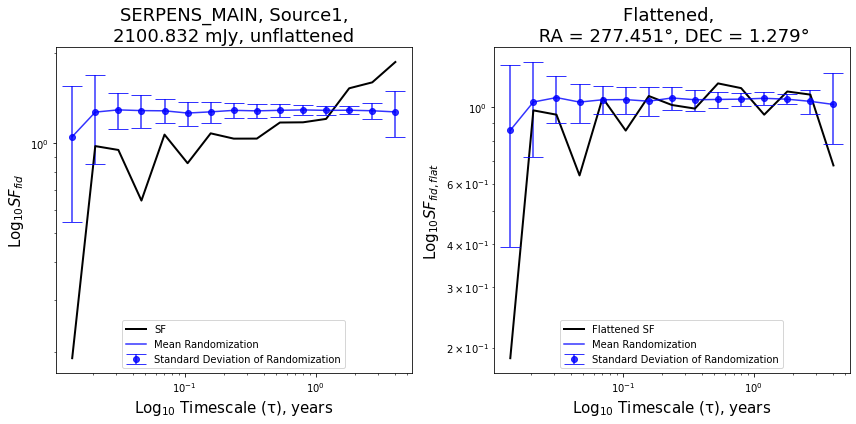

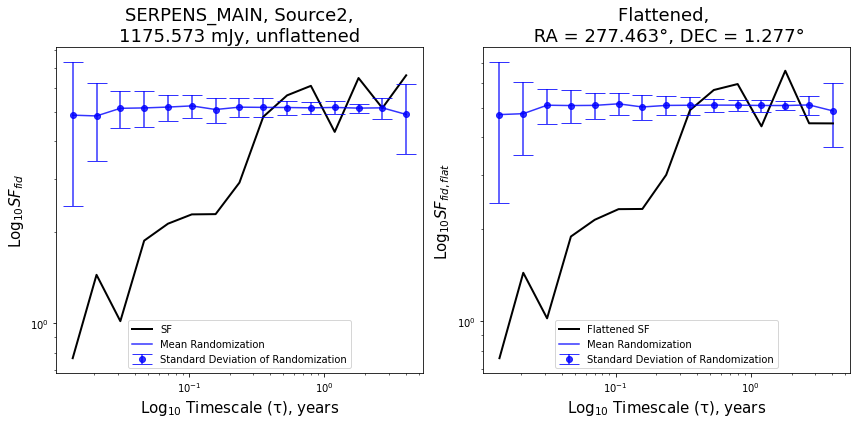

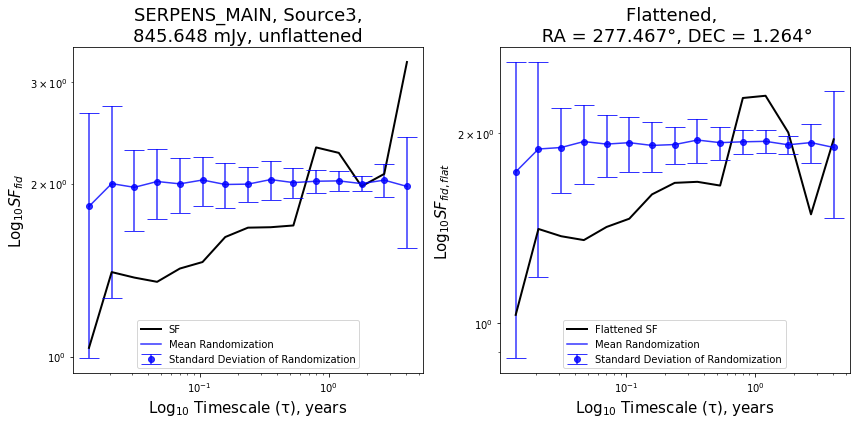

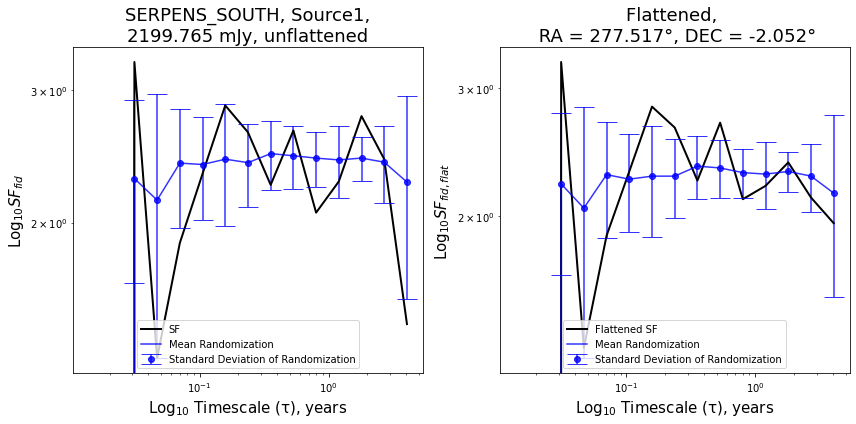

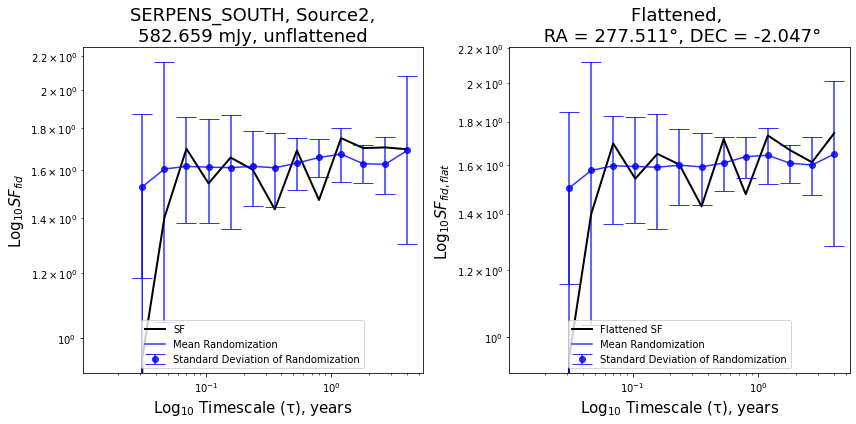

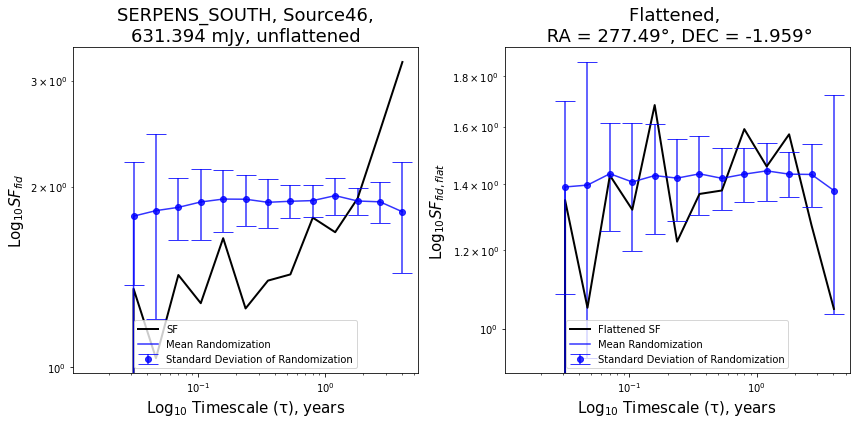

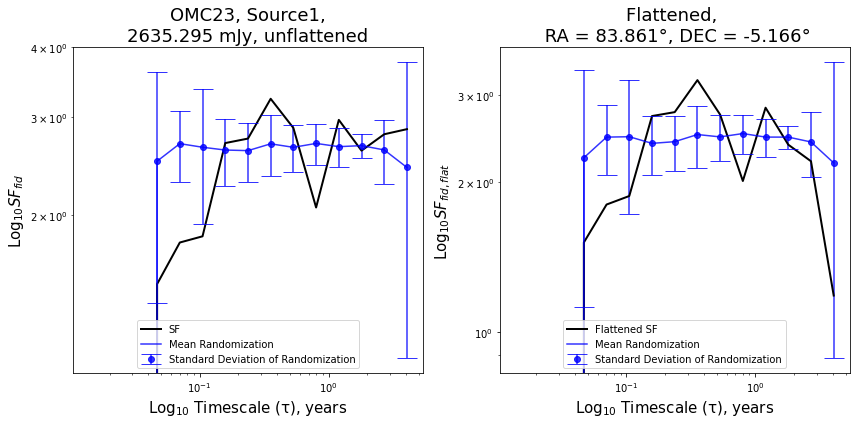

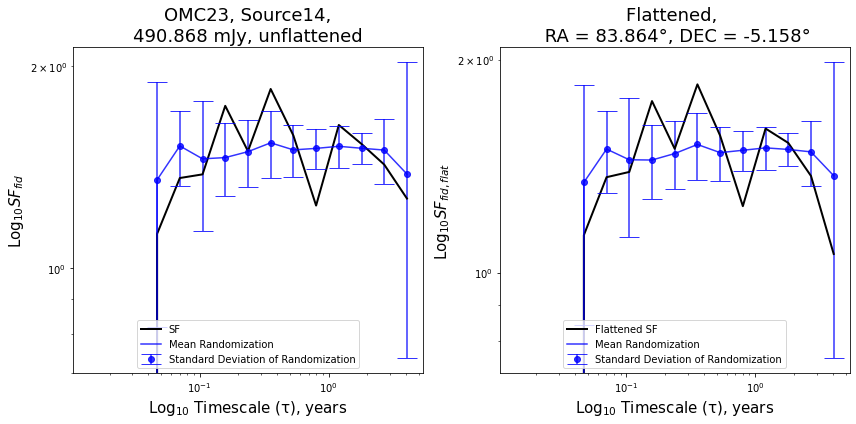

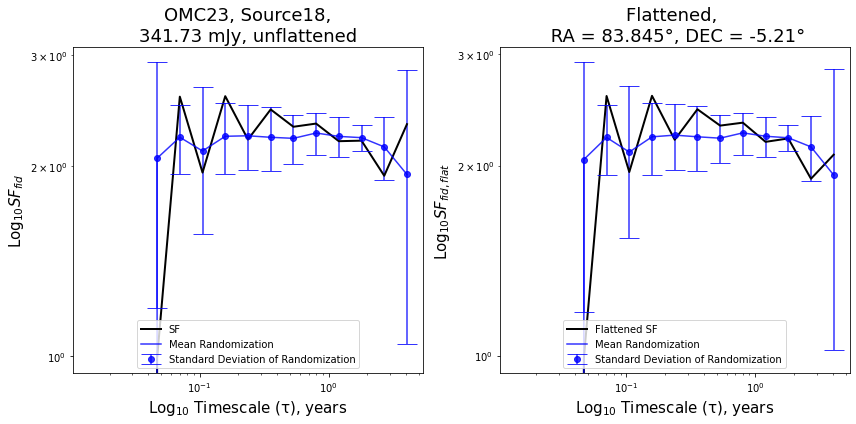

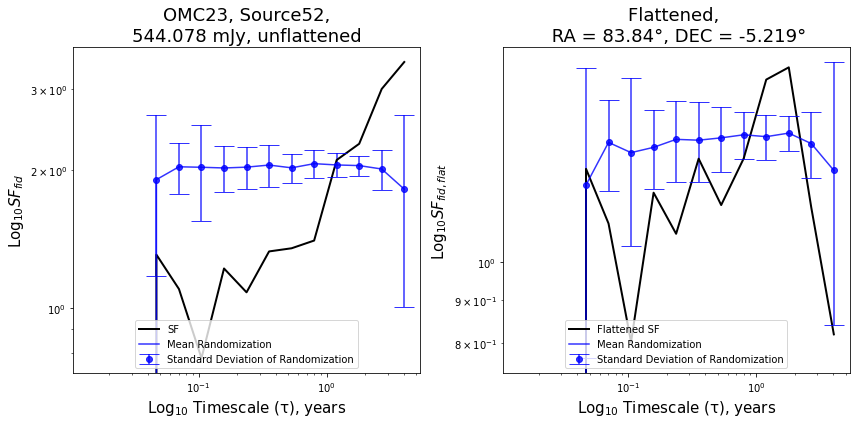

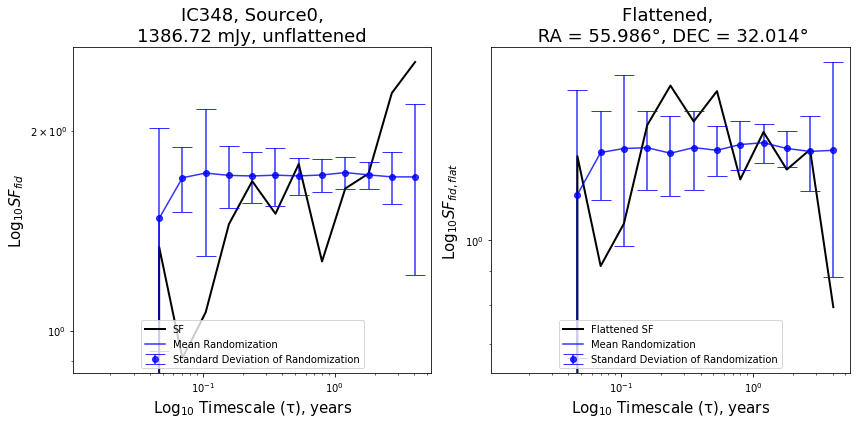

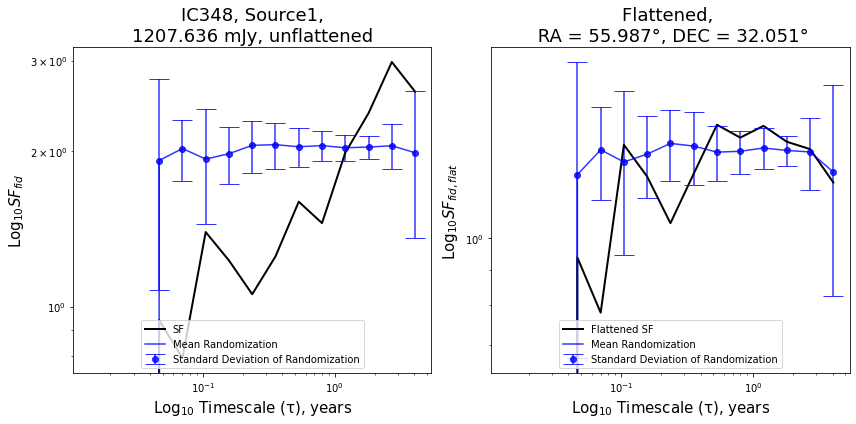

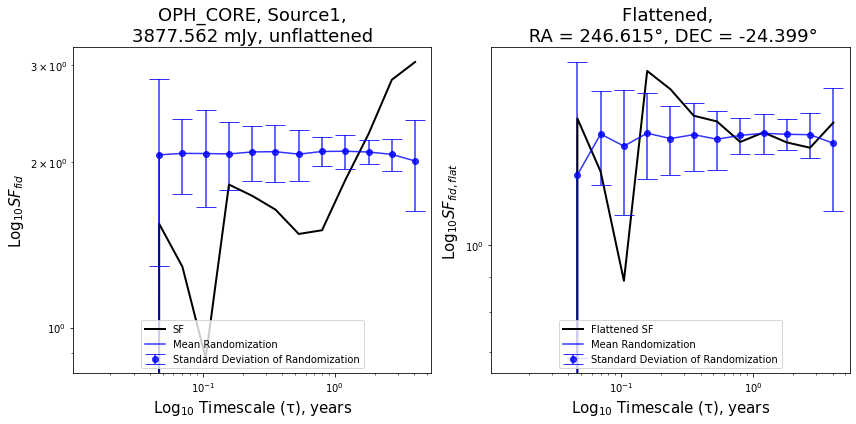

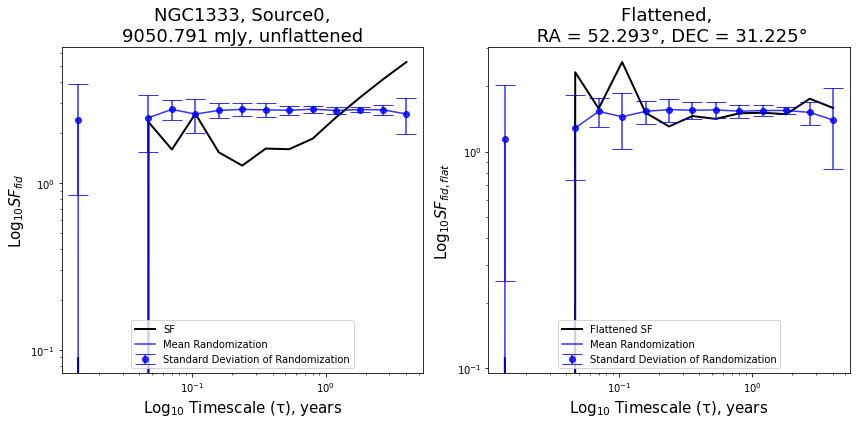

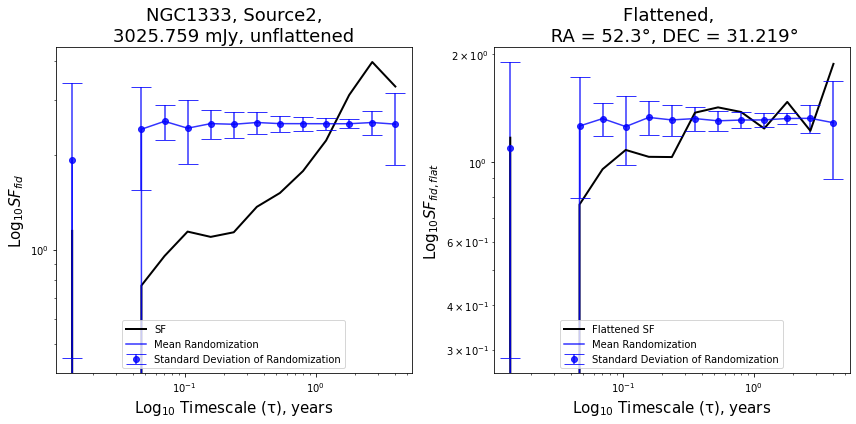

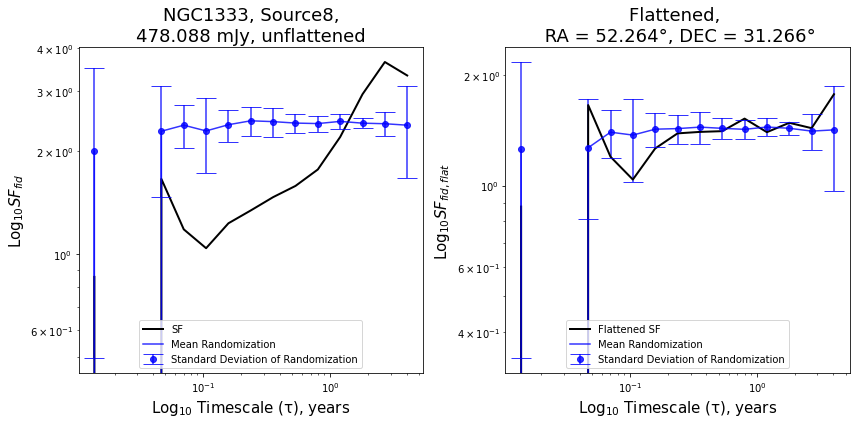

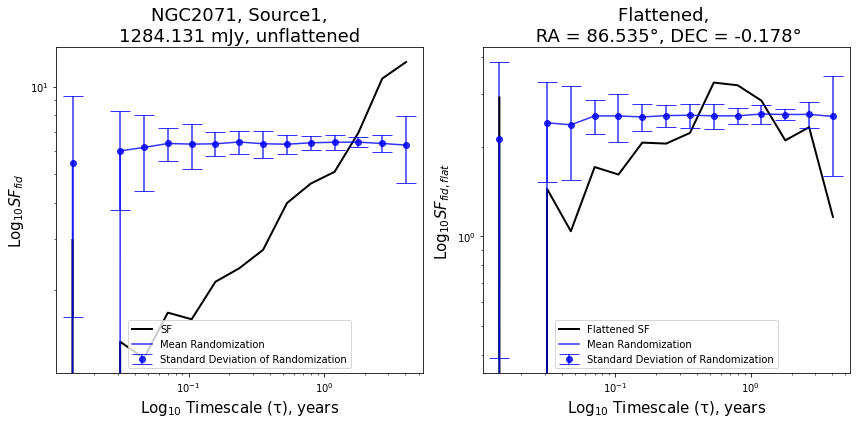

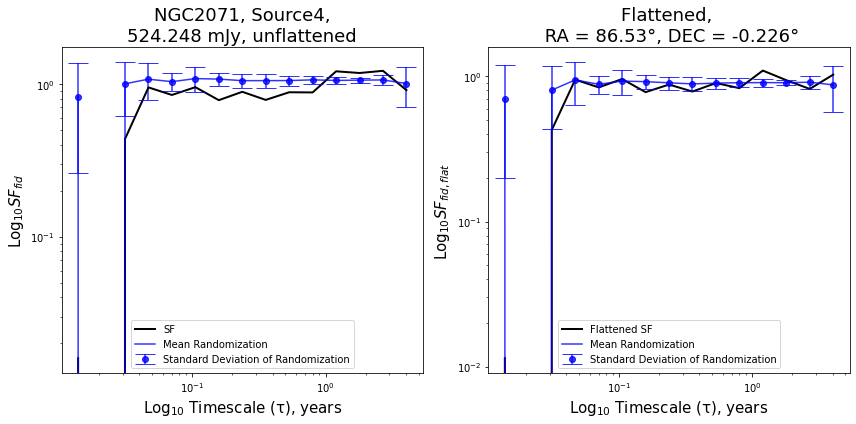

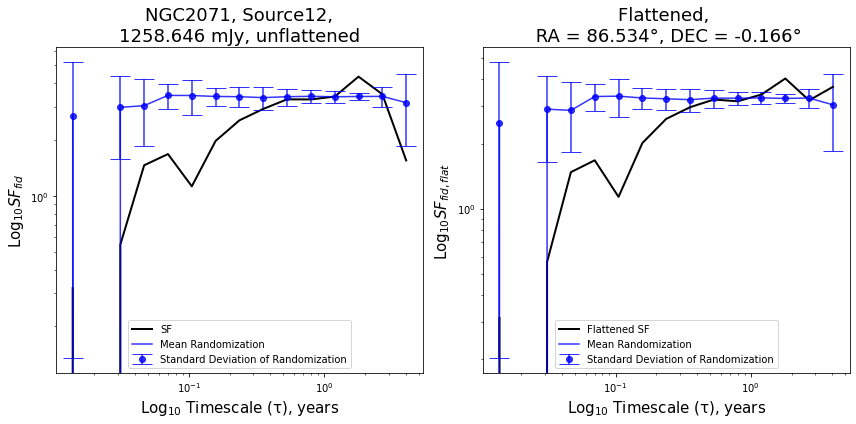

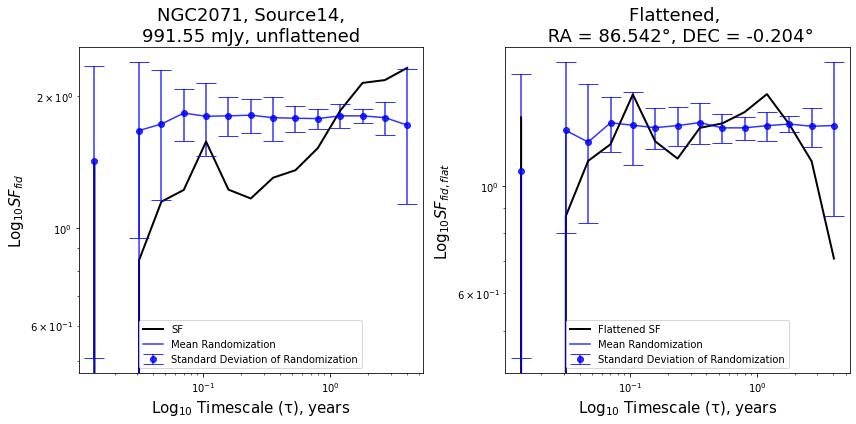

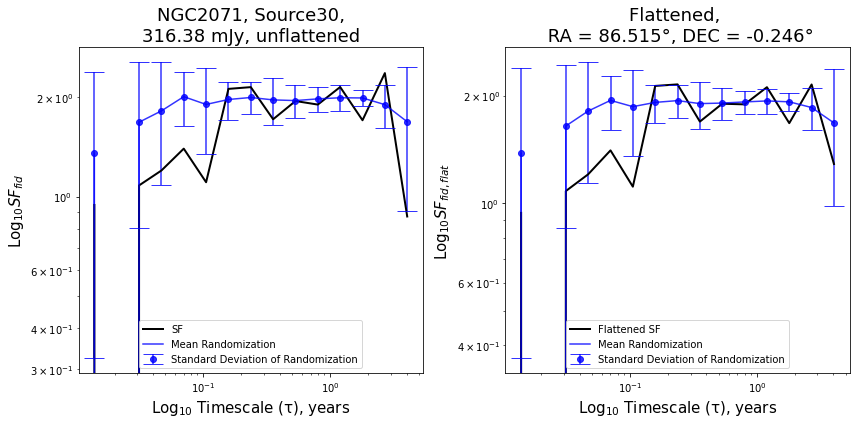

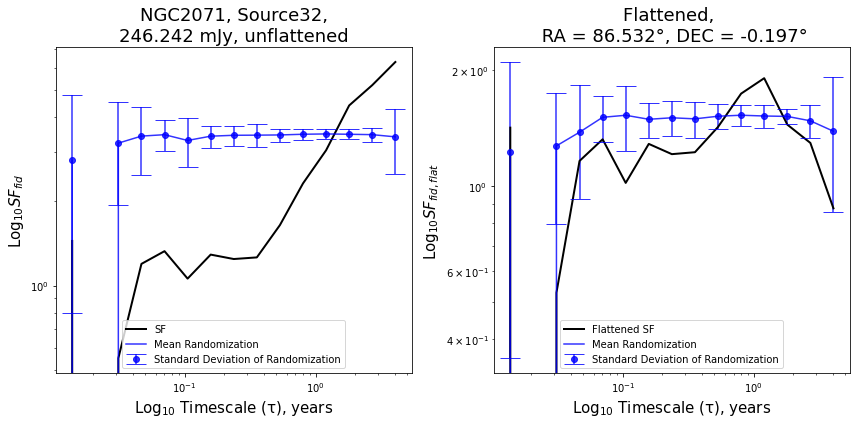

In [20]:
## Plotting SF_fiducial with mean randomized values and stdev error bars for all sources, flat vs unflat ##

with matplotlib.backends.backend_pdf.PdfPages('Plots/Specific/SF_FlatvsUnflat.pdf') as pdf:
    
    ## Timescale pairs histogram ##
    
    plt.figure(figsize=(6,6))
    plt.title('Frequency of Timescale Pairs', fontsize=20)
    plt.ylabel('Log$_{10}$ Frequency', fontsize=18)
    plt.xlabel('Log$_{10}$ Timescale Pairs (Years)', fontsize=18)

    plt.hist(dtime[0], bins_time)

    plt.axvline(x=bins_time[2], color='r', linestyle='dashed')
    plt.axvline(x=bins_time[-2], color='r', linestyle='dashed')

    plt.yscale('log')
    plt.xscale('log')
    
    pdf.savefig() #Adds the plot to the pdf on a separate page
    plt.tight_layout()
    plt.show()
    

    ## Structure function ##
    
    #Going through each region and plotting each source
    for i in range(num_regions):
        for j in range(int(len(indexes[i]))):
            
            fig, axs = plt.subplots(1,2, figsize=(12,6))
            
            
            
            ## Source, unflattened (1st row, 1st column) ##
            
            #Original SF values
            axs[0].loglog(bins_time[:-1], SF_fid[i][j], color='k', linewidth=2)
            
            #Mean random SF values
            axs[0].loglog(bins_time[:-1], SF_randmeans[i][j], color='b', alpha=0.8)
            
            #Error bars for the mean random SF
            axs[0].errorbar(bins_time[:-1], SF_randmeans[i][j], yerr=err[i][j], \
                           color='b', alpha=0.8, fmt='o', markersize=6, capsize=10)
            
            
            axs[0].set_title(regions[i] + ', Source' + str(indexes[i][j]) + ',\n'+ str(flux_mean[i][j]) +\
                             ' mJy, unflattened', fontsize=18)

            
            axs[0].set_xlabel('Log$_{10}$ Timescale (τ), years', fontsize = 15)
            axs[0].set_ylabel('Log$_{10} SF_{fid}$', fontsize = 15)
            axs[0].legend(['SF', 'Mean Randomization',\
                          'Standard Deviation of Randomization'], loc='lower center')
            
            
            
            ## Source, flattened (1st row, 2nd column) ##
            
            #Original, flattened SF values
            axs[1].loglog(bins_time[:-1], SF_flat_fid[i][j], color='k', linewidth=2)
            
            #Mean random SF values
            axs[1].loglog(bins_time[:-1], SF_flat_randmeans[i][j], color='b', alpha=0.8)
            
            #Error bars for the mean random SF
            axs[1].errorbar(bins_time[:-1], SF_flat_randmeans[i][j], yerr=err_flat[i][j], \
                           color='b', alpha=0.8, fmt='o', markersize=6, capsize=10)
            
            
            axs[1].set_title('Flattened, \n RA = ' +repr(RA[i][j])+'°, DEC = '+repr(DEC[i][j])+'°', \
                             fontsize=18)
            
            axs[1].set_xlabel('Log$_{10}$ Timescale (τ), years', fontsize = 15)
            axs[1].set_ylabel('Log$_{10} SF_{fid,flat}$', fontsize = 15)
            axs[1].legend(['Flattened SF', 'Mean Randomization',\
                          'Standard Deviation of Randomization'], loc='lower center')
        
        
            fig.tight_layout()
            pdf.savefig() #Adds the plot to the pdf on a separate page
            plt.show()